In [1]:
import os

from descartes.patch import PolygonPatch
import joblib
import geopandas as gpd
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
d6_bbls = np.load("data/bimg_labels_d6.npy")
d9_bbls = np.load("data/bimg_labels_d9.npy")

# we will impute using surface area as our distance metric
pluto = gpd.read_file("data/pluto/MNMapPLUTO.shp")
pluto["surface_area"] = pluto["NumFloors"] * pluto.geometry.length

in_frame = pluto[(pluto.BBL.isin(np.unique(d6_bbls.ravel()))) | pluto.BBL.isin(np.unique(d9_bbls.ravel()))]
out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]

out_reset = out_frame.reset_index()

In [3]:
night="2017-10-01"
final_light_d6 = pd.read_csv("data/{}_d6_10m.csv".format(night, night))
final_light_d9 = pd.read_csv("data/{}_d9_10m.csv".format(night, night))
for df in (final_light_d6, final_light_d9):
    del df["Unnamed: 0"]
    del df["lat"]
    del df["lng"]
final_light_d6 = final_light_d6.set_index("BBL").swapaxes(1, 0)
final_light_d9 = final_light_d9.set_index("BBL").swapaxes(1, 0)

concatd = pd.concat((final_light_d6, final_light_d9))
final_light = concatd.groupby(concatd.index).mean()

nearest_neighbors = [np.abs(in_frame.surface_area - osa).sort_values()[:10].index\
                     for osa in out_frame.surface_area]
out_reset["nearest_ix"] = nearest_neighbors

In [4]:
final_light_means = final_light.mean()

In [28]:
final_light.iloc[0]

BBL
1.000048e+09    0.100339
1.000090e+09    0.076647
1.000100e+09    0.076522
1.000130e+09    0.079855
1.000130e+09    0.083981
1.000150e+09    0.083535
1.000158e+09    0.080783
1.000158e+09    0.091208
1.000160e+09    0.090256
1.000160e+09    0.128769
1.000160e+09    0.100598
1.000160e+09    0.106303
1.000160e+09    0.100118
1.000160e+09    0.075737
1.000160e+09    0.088281
1.000160e+09    0.089481
1.000160e+09    0.095503
1.000160e+09    0.093162
1.000160e+09    0.087445
1.000160e+09    0.086678
1.000160e+09    0.079411
1.000160e+09    0.117179
1.000168e+09    0.101197
1.000168e+09    0.075355
1.000170e+09    0.083158
1.000188e+09    0.130328
1.000200e+09    0.092767
1.000200e+09    0.077328
1.000200e+09    0.081261
1.000210e+09    0.080932
                  ...   
1.008990e+09    0.079399
1.009000e+09    0.097359
1.009000e+09    0.087013
1.009010e+09    0.075434
1.009010e+09    0.077883
1.009010e+09    0.078023
1.009010e+09    0.076696
1.009020e+09    0.077114
1.009040e+09    0.074

In [5]:
in_frame_bgt = in_frame.merge(final_light_means.to_frame(), left_on='BBL', right_index=True)
in_frame_bgt['brightness'] = in_frame_bgt[0]
in_frame_bgt['scaled_bgt'] = in_frame_bgt['brightness'] * in_frame_bgt['surface_area']


In [6]:
medians = []
for i, indices in enumerate(out_reset["nearest_ix"]):
    cbbl = in_frame.loc[indices].BBL
    median = final_light[cbbl].mean().median()
    medians.append((i, median))
medians = np.array(medians, dtype=[('ix', int), ('median', np.float64)])
med_ix = pd.Series(medians['median'], index=out_reset.index)
out_reset["brightness"] = med_ix
out_reset['scaled_bgt'] = out_reset['brightness'] * out_reset['surface_area']

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


xdiff: 18000
ydiff: 20800


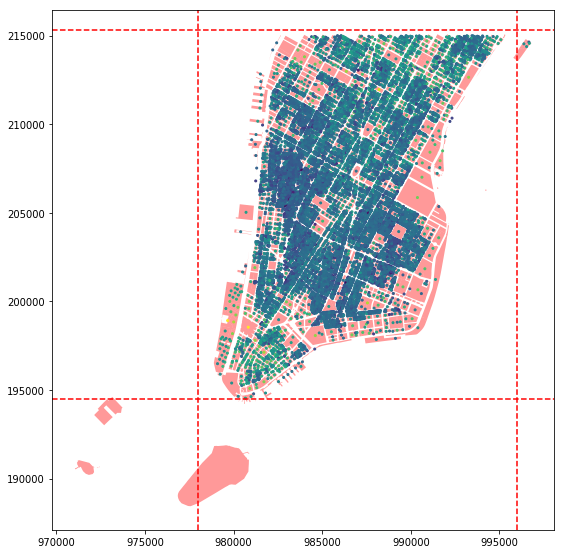

In [7]:
ax = in_frame.plot(figsize=(9, 16), alpha=.4, color='red')
out_frame.plot(ax=ax, alpha=.4, color='red')


ax.scatter(in_frame_bgt.geometry.centroid.x, 
           in_frame_bgt.geometry.centroid.y, 
           c=np.log(in_frame_bgt['scaled_bgt']), s=4)
ax.scatter(out_reset.geometry.centroid.x, 
           out_reset.geometry.centroid.y, 
           c=np.log(out_reset['scaled_bgt']), s=4)

xmax = 996000
xmin = 978000
ymax = 215300
ymin = 194500
ax.axvline(xmin, c='red', linestyle='dashed')
ax.axvline(xmax, c='red', linestyle='dashed')
ax.axhline(ymax, c='red', linestyle='dashed')
ax.axhline(ymin, c='red', linestyle='dashed')
print("xdiff: {}".format(xmax - xmin))
print("ydiff: {}".format(ymax - ymin))

In [10]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

gridx = np.linspace(xmin, xmax, (xmax - xmin)/100 )
gridy = np.linspace(ymin, ymax, (ymax - ymin)/100 )
xx, yy = np.meshgrid(gridx, gridy)

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [12]:
get_filt = lambda df: (df.geometry.centroid.x > xmin) & (df.geometry.centroid.x < xmax)\
                    & (df.geometry.centroid.y > ymin) & (df.geometry.centroid.y < ymax)
in_considered = in_frame_bgt[get_filt(in_frame_bgt)]
out_considered = out_reset[get_filt(out_reset)]
full_x = np.concatenate((in_considered.geometry.centroid.x.values, out_considered.geometry.centroid.x.values))
full_y = np.concatenate((in_considered.geometry.centroid.y.values, out_considered.geometry.centroid.y.values))
full_z = np.concatenate((in_considered.scaled_bgt.values, out_considered.scaled_bgt.values))
full_z = np.log(full_z + 1)

OK = OrdinaryKriging(full_x, full_y,  full_z, variogram_model='gaussian', nlags=50,
                     verbose=True)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 2.936825791619991
Full Sill: 3.967720689573639
Range: 24913.716528738216
Nugget: 1.0308948979536476 

Calculating statistics on variogram model fit...


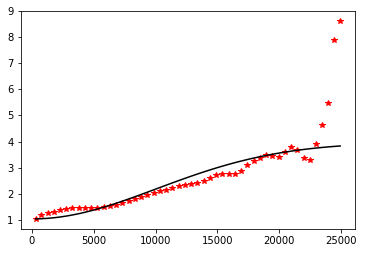

In [13]:
OK.display_variogram_model()

In [14]:
# specific numbers of nearest neighbors
nn_specs = (25, 50, 100, 200, 400)
zs = []
for n_neighbors in nn_specs:
    z, ss = OK.execute('grid', gridx, gridy, n_closest_points=n_neighbors, backend='C')
    zs.append(z)

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [25]:
yy[0]

array([194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 194500., 194500., 194500., 194500., 194500., 194500.,
       194500., 1945

Text(0.5,1,'Kriging will 25nn')

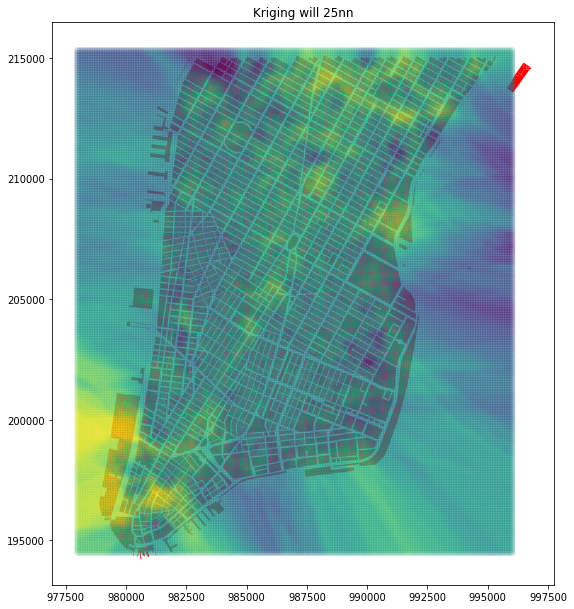

In [15]:
IX = 0

fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=zs[IX], alpha=.2)
ax.set_title("Kriging will {}nn".format(nn_specs[IX]))

Text(0.5,1,'Kriging will 50nn')

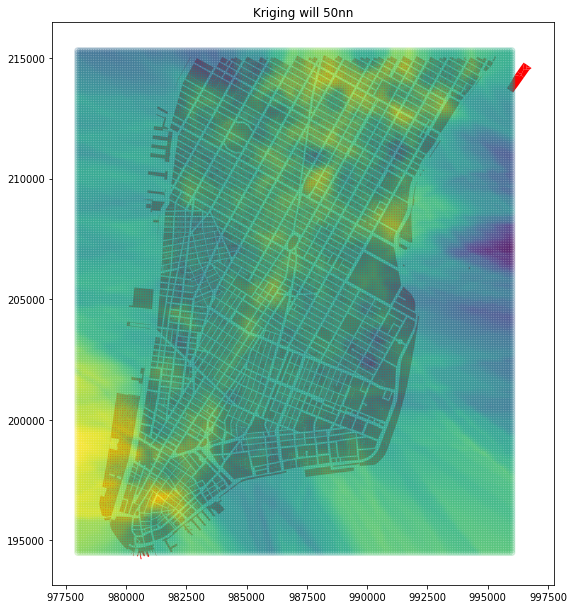

In [26]:
IX = 1

fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=zs[IX], alpha=.2)
ax.set_title("Kriging will {}nn".format(nn_specs[IX]))

In [ ]:
out_krige = 

Text(0.5,1,'Kriging will 200nn')

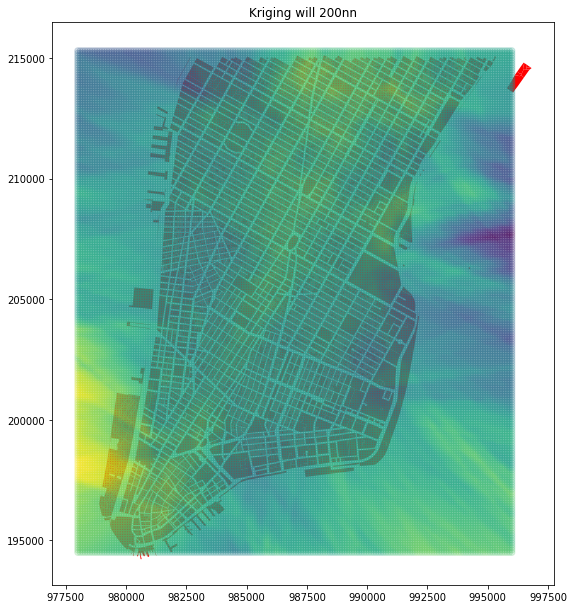

In [17]:
IX = -2

fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=zs[IX], alpha=.2)
ax.set_title("Kriging will {}nn".format(nn_specs[IX]))

Text(0.5,1,'Kriging will 400nn')

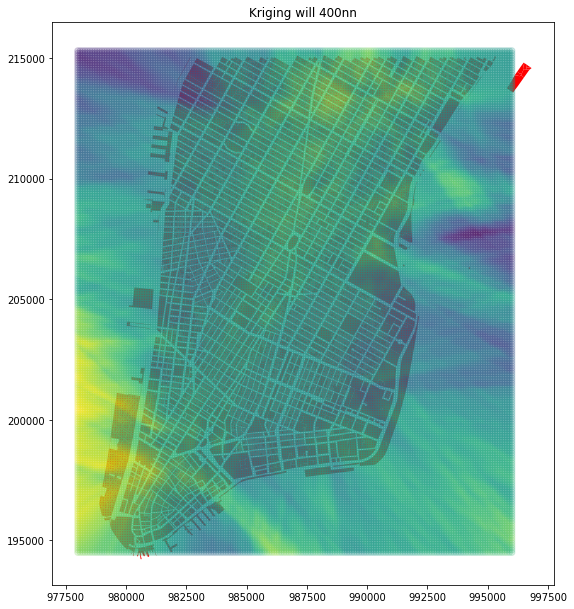

In [18]:
IX = -1

fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=zs[IX], alpha=.2)
ax.set_title("Kriging will {}nn".format(nn_specs[IX]))

In [ ]:
plt.imshow(zs[-1])

In [ ]:
IX = -3

fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=zs[IX], alpha=.2)
ax.set_title("Kriging will {}nn".format(nn_specs[IX]))

### 6-binned variogram below here

In [ ]:
# DO NOT TOUCH, this was 6 bins, which was Bad
OK.display_variogram_model()

In [ ]:
# solving the entire kriging
z, ss = OK.execute('grid', gridx, gridy)#, n_closest_points=25, backend='C')



fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=np.log(z), alpha=.2)
ax.set_title("Kriging will all points, full inverse")

In [ ]:
nn_specs = (25, 50, 100, 200, 400, 500)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=np.log(zs[0]), alpha=.2)
ax.set_title("Kriging will 25nn")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=np.log(zs[1]), alpha=.2)
ax.set_title("Kriging will 50nn")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=np.log(zs[2]), alpha=.2)
ax.set_title("Kriging will 100nn")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
in_frame.plot(ax=ax, color='red', alpha=1)
filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
out_reset[filt].plot(ax=ax, color='red', alpha=1)

ax.scatter(xx, yy, c=np.log(zs[3]), alpha=.2)
ax.set_title("Kriging will 500nn")

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 40))
axes = axes.flatten()
for ax, z in zip(axes, zs):
    in_frame.plot(ax=ax, color='red', alpha=1)
    filt = (out_reset.geometry.centroid.x > xmin - 1000) & (out_reset.geometry.centroid.y > ymin - 1000)
    out_reset[filt].plot(ax=ax, color='red', alpha=1)

    ax.scatter(xx, yy, c=z, alpha=.2)
    ax.set_title("Windowed kriging, 25-500nn")